In [9]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:

# 준비된 수술 환자 데이터를 불러들입니다.
raw_df = pd.read_csv("../dataset/ThoraricSurgery.csv", header=None)
data_vale=raw_df.values

# 환자의 기록과 수술 결과를 X와 Y로 구분하여 저장합니다.
X = data_vale[:,0:17]
Y = data_vale[:,17:18]




In [8]:

# 전체 데이터에서 학습 데이터와 테스트 데이터(0.2)로 구분
X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.3)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2)


밸런스가 맞는 샘플인 경우...
1. oversample : ex) 이진 분류에서 두 분류에 sample의 개수가 비슷해야 하는데 한쪽으로 쏠릴 경우 모자라는 분류의 data를 중복해서 늘려주는 방식
2. undersample : ex) 이진 분류에서 두 분류에 sample의 개수가 비슷해야 하는데 한쪽으로 쏠릴 경우 많은 부분을 줄려서 벨런스를 맞춰주는 방식
3. 앙상블
4. augmentation : 확장 -> data 증강 방식 : 이미지를 변환

In [12]:

X_samp, y_samp = RandomOverSampler(sampling_strategy=0.7).fit_resample(X_train, Y_train)
X_under_samp, y_under_samp =RandomUnderSampler(sampling_strategy=0.7).fit_resample(X_train, Y_train)
print("train class bin : " , np.bincount(Y_train.flatten().astype('int8')))
print("train OverSampler class bin : " , np.bincount(y_samp.flatten().astype('int8')))
print("train UnderSampler class bin : " , np.bincount(y_under_samp.flatten().astype('int8')))
print("val class bin : " , np.bincount(Y_valid.flatten().astype('int8')))
print("test class bin : " , np.bincount(Y_test.flatten().astype('int8')))
# https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html


train class bin :  [225  38]
train OverSampler class bin :  [225 157]
train UnderSampler class bin :  [54 38]
val class bin :  [56 10]
test class bin :  [119  22]


In [13]:

# 딥러닝 구조를 결정합니다(모델을 설정하고 실행하는 부분입니다).
input_Layer = tf.keras.layers.Input(shape=(17,))
x = tf.keras.layers.Dense(20, activation='sigmoid')(input_Layer)
Out_Layer= tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [14]:

# 딥러닝을 실행합니다.
loss=tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.SGD(learning_rate=0.009)
metrics=tf.keras.metrics.binary_accuracy

model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
result = model.fit(X_train, Y_train, epochs=1000, batch_size=100, validation_data=(X_valid,Y_valid))
print(result.history.keys())


Epoch 1/1000
3/3 [==============================] - 2s 103ms/step - loss: 0.6639 - binary_accuracy: 0.7719 - val_loss: 0.6101 - val_binary_accuracy: 0.8333
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6296 - binary_accuracy: 0.7947 - val_loss: 0.5861 - val_binary_accuracy: 0.8182
Epoch 3/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.6039 - binary_accuracy: 0.7985 - val_loss: 0.5529 - val_binary_accuracy: 0.8182
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.5599 - binary_accuracy: 0.8023 - val_loss: 0.5012 - val_binary_accuracy: 0.8030
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.5293 - binary_accuracy: 0.8023 - val_loss: 0.4922 - val_binary_accuracy: 0.8030
Epoch 6/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.5159 - binary_accuracy: 0.8023 - val_loss: 0.4862 - val_binary_accuracy: 0.8030
Epoch 7/1000
3/3 [==============================] - 0s 18ms/step - lo

-----
5/5 [==============================] - 0s 2ms/step - loss: 0.4392 - binary_accuracy: 0.8440
[0.4392029643058777, 0.8439716100692749]
5/5 [==============================] - 0s 2ms/step - loss: 0.4392 - binary_accuracy: 0.8440

 Accuracy: 0.8440


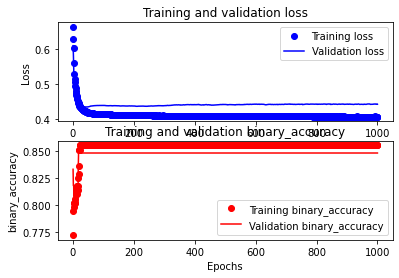

In [15]:

### history에서 loss와 val_loss의 key를 가지는 값들만 추출
loss = result.history['loss']
val_loss = result.history['val_loss']

### loss와 val_loss를 그래프화
epochs = range(1, len(loss) + 1)
plt.subplot(211)  ## 2x1 개의 그래프 중에 1번째
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### history에서 binary_accuracy와 val_binary_accuracy key를 가지는 값들만 추출
rmse = result.history['binary_accuracy']
val_rmse = result.history['val_binary_accuracy']
epochs = range(1, len(rmse) + 1)
### binary_accuracy와 val_binary_accuracy key를 그래프화
plt.subplot(212)  ## 2x1 개의 그래프 중에 2번째
plt.plot(epochs, rmse, 'ro', label='Training binary_accuracy')
plt.plot(epochs, val_rmse, 'r', label='Validation binary_accuracy')
plt.title('Training and validation binary_accuracy')
plt.xlabel('Epochs')
plt.ylabel('binary_accuracy')
plt.legend()

# 결과를 출력합니다.
print("-----")
print(model.evaluate(X_test, Y_test))
print("\n Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

plt.show()